# MPAS-Ocean Regions and Masking
***

This notebook documents the development of MPAS-Ocean masks for the purposes of watermass analysis.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs, feature
from geometric_features import GeometricFeatures

***

### Masking and regions

[Predefined regions](https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data/ocean/region) are available from the MPAS [geometric features](http://mpas-dev.github.io/geometric_features/stable/quick_start.html) package in `geojson` format. The `geometric_features` package provides an interface to accessing and manipulating these regions. Below is an example of aggregating a region containing the North Atlantic areas of mode water formation.

In [2]:
mask_path = '/pscratch/sd/b/bmoorema/maskfiles/'

In [ ]:
# Subbasins to aggregate
names = [
    'North Atlantic Ocean',
    'Labrador Sea',
    'Irminger Sea',
    'Greenland Sea',
    'Norwegian Sea',
    'North Sea',
    'Celtic Sea',
    'Bay of Biscay',
]

# Read subbasins into merged feature collection
gf = GeometricFeatures()
fc = gf.read('ocean', 'region', names)

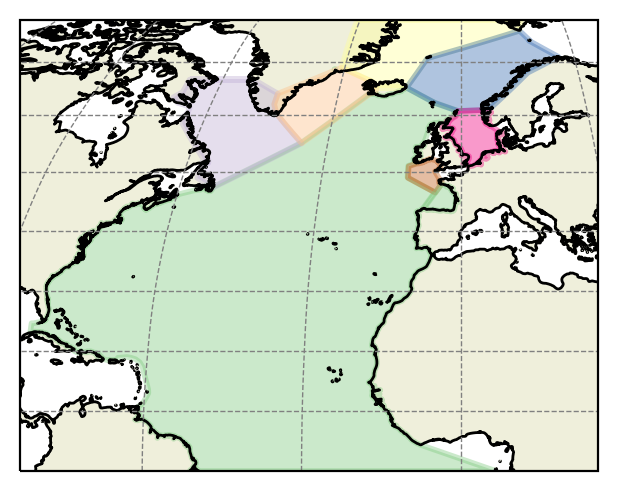

In [4]:
# Plot merged subbasins
fig = fc.plot('robin', figsize=(4, 4))

In [5]:
# Combine merged basins to single basin
fc = fc.combine('North Atlanic Mode Water Region')

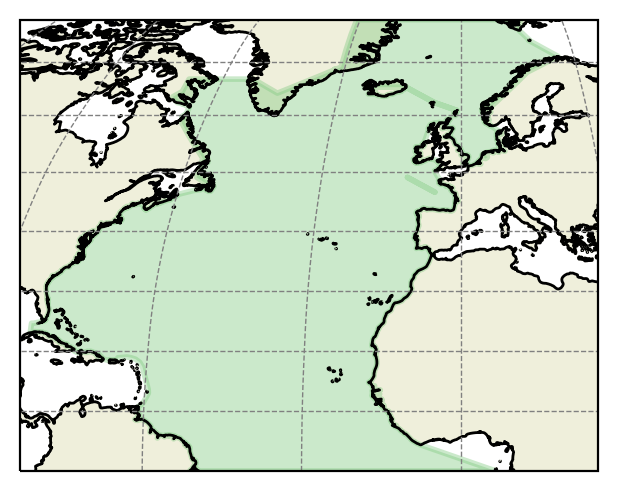

In [6]:
# Plot single basin
fig = fc.plot('robin', figsize=(4, 4))

In [7]:
# Write combined subbasins to geojson
fc.to_geojson(mask_path + 'NAmodewater.geojson')

From here, I run `MpasMaskCreator.x` at command line with an MPAS-O grid file and `NAmodewater.geojson` as inputs. Could also be done in Python with `mpas_tools.mesh.conversion.mask`, but needs to be done with `compass` environment loaded in the shell since a subprocess to `MpasMaskCreator.x` is called.

***

### Applying a mask to MPAS-Ocean results

The output of `MpasMaskCreator.x` was a netcdf file containing several mask variables (I named mine `NAmodewater_maskfile.nc`). Next I open this file along with a grid file and a results file to apply the mask. I'm using `EC30to60E2r2`.

In [8]:
# Load coordinates
gridfile = '/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
with xr.open_dataset(gridfile) as ds:
    lon, lat = [np.rad2deg(ds[name].values) for name in ('lonCell', 'latCell')]
lon[lon > 180] = lon[lon > 180] - 360

# Load mask
with xr.open_dataset(mask_path + 'NAmodewater_maskfile.nc') as ds:
    mask = ds.regionCellMasks[:, 0].values.astype(bool)

# Load MPAS-O temperature
results_path = '/global/cfs/cdirs/m4259/E3SMv2_1/20220715.submeso.piControl.ne30pg2_EC30to60E2r2.chrysalis/ocn/hist/'
fn = '20220715.submeso.piControl.ne30pg2_EC30to60E2r2.chrysalis.mpaso.hist.am.timeSeriesStatsMonthly.0001-01-01.nc'
with xr.open_dataset(results_path + fn) as ds:
    T = ds.timeMonthly_avg_activeTracers_temperature[0, :, 0].values

# Mask variables
lon, lat, T = lon[mask], lat[mask], T[mask]

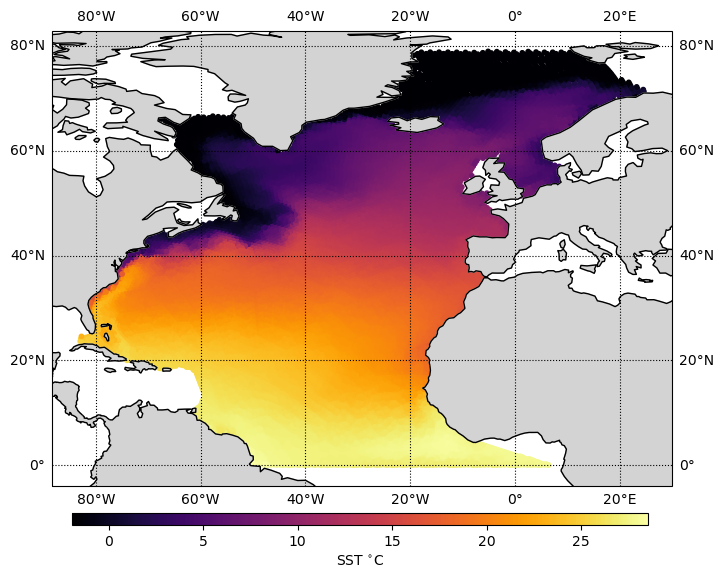

In [12]:
# Plot temperature
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': crs.PlateCarree()})
ax.add_feature(feature.LAND, color='lightgray', zorder=1)
ax.coastlines(zorder=1)
ax.gridlines(linestyle=':', color='k', draw_labels=True)
c = ax.scatter(lon, lat, s=10, c=T, transform=crs.PlateCarree(), cmap='inferno', zorder=0)
cax = fig.add_axes([0.15, 0.05, 0.72, 0.02])
fig.colorbar(c, cax=cax, label='SST $^{\\circ}$C', orientation='horizontal')